In [1]:

import os
import warnings

warnings.filterwarnings("ignore")

os.chdir("../../..")

In [2]:
import warnings
from pathlib import Path
import pandas as pd
import numpy as np
import torch
import copy


import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateLogger
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.data import GroupNormalizer

from pytorch_forecasting.metrics import PoissonLoss, QuantileLoss, SMAPE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [3]:
from pytorch_forecasting.data.examples import get_stallion_data

data = get_stallion_data()

# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.sample(10, random_state=521)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
291,Agency_25,SKU_03,0.5076,2013-01-01,492612703,718394219,25.845238,1264.162234,1152.473405,111.688829,...,-,-,-,8.835008,228,0,1,-0.678062,1225.306376,99.650400
871,Agency_29,SKU_02,8.7480,2015-01-01,498567142,762225057,27.584615,1316.098485,1296.804924,19.293561,...,-,-,-,1.465966,177,24,1,2.168825,1634.434615,11.397086
19532,Agency_47,SKU_01,4.9680,2013-09-01,454252482,789624076,30.665957,1269.250000,1266.490490,2.759510,...,-,-,-,0.217413,322,8,9,1.603017,2625.472644,48.295650
2089,Agency_53,SKU_07,21.6825,2013-10-01,480693900,791658684,29.197727,1193.842373,1128.124395,65.717978,...,-,beer_capital,-,5.504745,240,9,10,3.076505,38.529107,2511.035175
9755,Agency_17,SKU_02,960.5520,2015-03-01,515468092,871204688,23.608120,1338.334248,1232.128069,106.206179,...,-,-,music_fest,7.935699,259,26,3,6.867508,2143.677462,396.022140
7561,Agency_05,SKU_03,1184.6535,2014-02-01,425528909,734443953,28.668254,1369.556376,1161.135214,208.421162,...,-,-,-,15.218151,21,13,2,7.077206,1566.643589,1881.866367
19204,Agency_11,SKU_05,5.5593,2017-08-01,623319783,1049868815,31.915385,1922.486644,1651.307674,271.178970,...,-,-,-,14.105636,17,55,8,1.715472,1385.225478,109.699200
8781,Agency_48,SKU_04,4275.1605,2013-03-01,509281531,892192092,26.767857,1761.258209,1546.059670,215.198539,...,-,-,music_fest,12.218455,151,2,3,8.360577,1757.950603,1925.272108
2540,Agency_07,SKU_21,0.0000,2015-10-01,544203593,761469815,28.987755,0.000000,0.000000,0.000000,...,-,-,-,0.000000,300,33,10,-18.420681,0.000000,2418.719550
12084,Agency_21,SKU_03,46.3608,2017-04-01,589969396,940912941,32.478910,1675.922116,1413.571789,262.350327,...,-,-,-,15.654088,181,51,4,3.836454,2034.293024,109.381800


In [6]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],#list of column names identifying a timeseries
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set). minimum allowed length to encode
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,#minimum time index from where to start predictions
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],# list of categorical variables that do not change over time, entries can be also lists which are then encoded together (e.g. useful for product categories)
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],#list of continuous variables that do not change over time
    time_varying_known_categoricals=["special_days", "month"],#list of categorical variables that change over time and are know in the future, entries can be also lists which are then encoded together (e.g. useful for special days or promotion categories)
    # dictionary mapping a name to a list of columns in the data. The name should be present in a categorical or real class argument, to be able to encode or scale the columns by group.
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],# list of continuous variables that change over time and are know in the future
    time_varying_unknown_categoricals=[],#list of categorical variables that change over time and are not know in the future, entries can be also lists which are then encoded together (e.g. useful for weather categories)
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],# list of continuous variables that change over time and are not know in the future
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], coerce_positive=1.0 #transformer that takes group_ids, target and time_idx to return normalized target
    ),  # use softplus with beta=1.0 and normalize by group
    add_relative_time_idx=True,#if to add a relative time index as feature
    add_target_scales=True,#if to add scales for target to static real features
    add_encoder_length=True,# if to add decoder length to list of static real variables.
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)#Generate dataset with different underlying data but same variable encoders and scalers, etc.

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)#Get dataloader from dataset.
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

**to_dataloader**

First entry is a dictionary with the entries
encoder_cat
encoder_cont
encoder_target
encoder_lengths
decoder_cat
decoder_cont
decoder_target
decoder_lengths
Second entry is target

In [24]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, y in iter(val_dataloader)])#concatenate y. for x, y in ... it's iterating two elements at a time. This includes a dictionary and values
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

293.0088195800781

In [50]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, y in iter(val_dataloader)])#concatenate y. for x, y in ... it's iterating two elements at a time. 
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

293.0088195800781

In [51]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate.  hidden size of network which is its main hyperparameter and can range from 8 to 512
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,# number of attention heads (4 is a good default)
    dropout=0.1,  # between 0.1 and 0.3 are good values.  dropout rate
    hidden_continuous_size=8,  # set to <= hidden_size. default for hidden size for processing continous variables (similar to categorical embedding size)
    output_size=7,  # 7 quantiles by default.  number of outputs (e.g. number of quantiles for QuantileLoss)
    loss=QuantileLoss(),# loss function taking prediction and targets
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,#patience after which learning rate is reduced by a factor of 10
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 29.6k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | ModuleDict                      | 1 K   
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3 K   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8 K   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2 K   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1 K   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1 K   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1 K 

Saving latest checkpoint..
LR finder stopped early due to diverging loss.


suggested learning rate: 0.021877616239495523


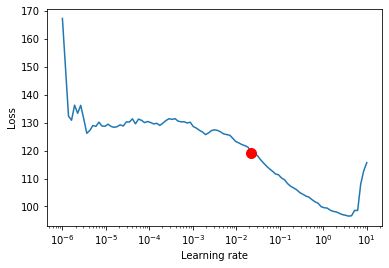

In [52]:
# find optimal learning rate
res = trainer.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [55]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateLogger()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    early_stop_callback=early_stop_callback,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 29.6k


In [59]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | ModuleDict                      | 1 K   
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3 K   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8 K   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2 K   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1 K   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1 K   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1 K 

1

In [58]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [60]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [61]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(257.0167)

In [62]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

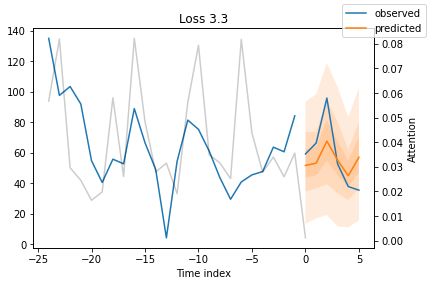

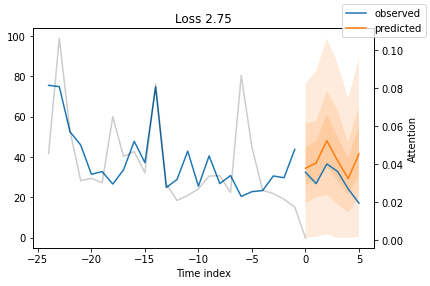

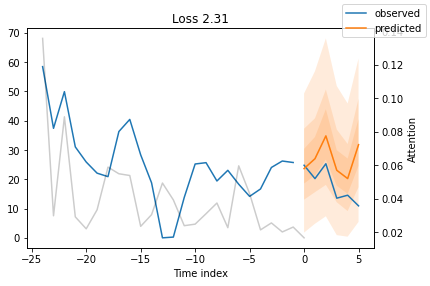

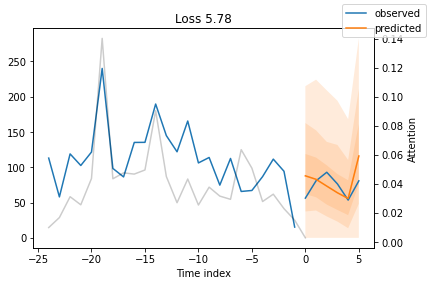

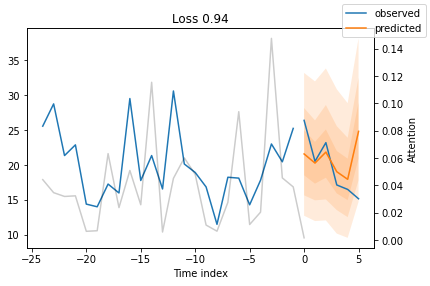

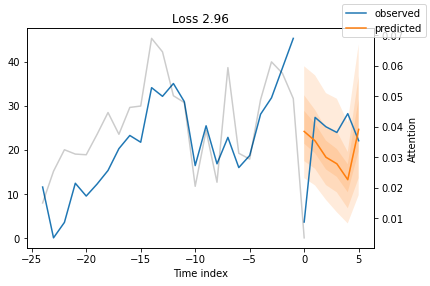

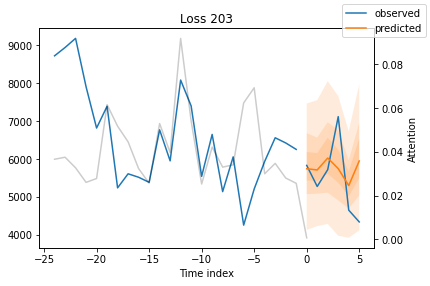

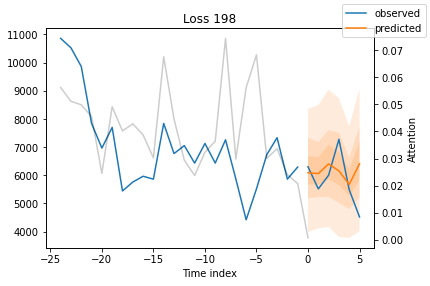

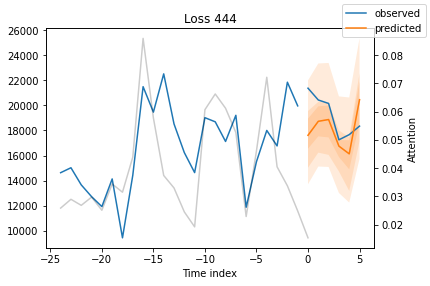

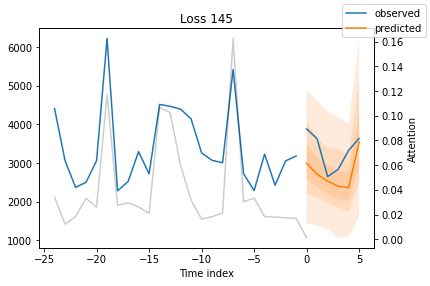

In [63]:

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);